In [3]:
import sys, pathlib
sys.path.append(str(pathlib.Path().resolve() / "src"))

from core import (
    load_data, load_eye_data_for_subject, build_trials_table_for_subject, 
    merge_trials_with_df_idx, select_correct_trials, apply_time_indexing, add_session_id_column,
    parse_target_columns, polar_to_cartesian, extract_session_subject_map, 
    filter_mat_data_by_trials, add_response_metrics, add_memory_delay_features
)

from viz import (
    plot_eye_endpoints, plot_error_histogram,
    plot_error_variability_vs_delay, plot_error_vs_prev_diff

)

In [4]:
data_path = "/home/aarghavan/nasShare/projects/labdul/Data_siegel/all_data_siegel_0.025.pkl"
data = load_data(data_path)

print(type(data))
if isinstance(data, dict):
    print(data.keys())
else:
    print(data)


<class 'dict'>
dict_keys(['trial', 'unit', 'session', 'spiketimes', 'trialsNeuron'])


In [5]:
# For all subjects combined
filtered_delsac = select_correct_trials(data, task_key="delsac")

In [6]:
# Convert time columns to indices and merge all sessions
df_idx = apply_time_indexing(filtered_delsac, task_key="delsac")

print(len(df_idx))
df_idx.head()

# Add clean session IDs
df_idx = add_session_id_column(df_idx, source_col="session")
df_idx["session_id"].head()


6652


[100725.3]    100725
[100725.6]    100725
[100725.7]    100725
[100725.8]    100725
[100725.9]    100725
Name: session_id, dtype: object

In [7]:
# 1) Parse targetPos -> targEcc, targAng (normalized to (-180, 180])
df_idx = parse_target_columns(df_idx, source_col="targetPos", ecc_col="targEcc", ang_col="targAng")

# 2) Polar → Cartesian
df_idx = polar_to_cartesian(df_idx, ecc_col="targEcc", ang_col="targAng", x_col="targX", y_col="targY")

# quick peek
df_idx[["targetPos", "targEcc", "targAng", "targX", "targY"]].head()

,targetPos,targEcc,targAng,targX,targY
[100725.3],"(6, 180)",6.0,180.0,-6.0,7.347881e-16
[100725.6],"(6, 300)",6.0,-60.0,3.0,-5.196152e+00
[100725.7],"(6, 0)",6.0,0.0,6.0,0.000000e+00
[100725.8],"(6, 240)",6.0,-120.0,-3.0,-5.196152e+00
[100725.9],"(6, 300)",6.0,-60.0,3.0,-5.196152e+00


In [8]:
session_subject_df, paula_sessions, rex_sessions = extract_session_subject_map(data, task_key="delsac")

display(session_subject_df.head())

print("Paula sessions:", paula_sessions)
print("Count:", len(paula_sessions))
print("Rex sessions:", rex_sessions)
print("Count:", len(rex_sessions))

,session_id,subject
0,100725,paula
1,100731,paula
2,100730,paula
3,100724,paula
4,100917,rex


Paula sessions: ['100725', '100731', '100730', '100724', '100726', '101202', '101216', '101207', '101206', '110111_01', '101210', '110111_02', '101128', '110107_01', '110115_01', '100828', '110107_02', '100802', '100817', '100803', '100804', '100820', '101122', '100823', '101123', '110110_02', '101127', '100826', '100827', '110110_01', '101124', '100819', '100824', '100818', '110106', '101209', '100706']
Count: 37
Rex sessions: ['100917', '100915', '101028', '100910', '110120', '110121', '100907', '100913', '101023', '100920', '101009', '101008', '100921', '101024', '101030', '101027']
Count: 16


In [9]:
EYE_DIR = "/home/aarghavan/nasShare/projects/labdul/Data_siegel/eyetracker_data"

# Paula
mat_data_paula, missing_paula, total_paula = load_eye_data_for_subject(EYE_DIR, paula_sessions)
print(f"Loaded Paula sessions: {len(mat_data_paula)}  | Missing: {missing_paula}")
print(f"Total trials for Paula: {total_paula:,}")

# Rex
mat_data_rex, missing_rex, total_rex = load_eye_data_for_subject(EYE_DIR, rex_sessions)
print(f"Loaded Rex sessions:   {len(mat_data_rex)}  | Missing: {missing_rex}")
print(f"Total trials for Rex:  {total_rex:,}")

Loaded Paula sessions: 36  | Missing: ['110106']
Total trials for Paula: 52,002
Loaded Rex sessions:   16  | Missing: []
Total trials for Rex:  21,972


In [10]:
# Paula
filtered_paula, summary_paula = filter_mat_data_by_trials(df_idx, mat_data_paula, ain_key="ain", schema_key="ainSchema")
display(summary_paula.head())

# Rex
filtered_rex, summary_rex = filter_mat_data_by_trials(df_idx, mat_data_rex, ain_key="ain", schema_key="ainSchema")
display(summary_rex.head())

# Example: inspect a session
sid = next(iter(filtered_paula.keys()))
print(sid, filtered_paula[sid]["ain"].shape, filtered_paula[sid]["kept_trial_ids"][:10])


,session_id,trials_total,trials_kept
0,100706,1300,124
1,100724,1373,139
2,100725,1307,141
3,100726,876,140
4,100730,1231,142


,session_id,trials_total,trials_kept
0,100907,1043,143
1,100910,1611,147
2,100913,1557,146
3,100915,1593,138
4,100917,1531,139


100706 (6001, 4, 124) [ 2  3  4  5  9 10 11 12 14 15]


# Calculate Base line fixation point 

In [11]:
df_trials_paula, fit_paula = build_trials_table_for_subject(filtered_paula, df_idx)
df_trials_rex,   fit_rex   = build_trials_table_for_subject(filtered_rex,   df_idx)



In [12]:
df_trials_paula[df_trials_paula["session_id"] == "100725"].head()

,session_id,trial_id,fixBaseX_raw,fixBaseY_raw,endX_raw,endY_raw,targX,targY,correct,responseTime_idx,responseDone_idx,fixptOff_idx,targX_raw_pred,targY_raw_pred,endErr_raw
263,100725,3,-5007.72,-15099.16,-2152.428571,-15311.428571,-6.0,7.347881e-16,1,5242.0,5250.0,5050.0,-1941.279039,-15166.874830,255.890424
264,100725,6,-5094.92,-14996.80,-6841.238095,-13387.857143,3.0,-5.196152e+00,1,5258.0,5267.0,5050.0,-6726.799021,-13113.079146,297.656260
265,100725,7,-4941.64,-14994.72,-7812.285714,-14835.523810,6.0,0.000000e+00,1,5175.0,5183.0,5050.0,-8008.080961,-14927.005170,216.112512
266,100725,8,-5069.48,-15079.68,-3710.809524,-13327.761905,-3.0,-5.196152e+00,1,5301.0,5309.0,5050.0,-3634.918061,-13263.673976,99.331650
267,100725,9,-4975.84,-15087.40,-6928.761905,-13329.523810,3.0,-5.196152e+00,1,5311.0,5323.0,5050.0,-6607.719021,-13203.679146,344.826641


In [13]:
merged_paula = merge_trials_with_df_idx(
    df_trials=df_trials_paula,
    df_idx=df_idx,
    trial_id_col="trial_id",
    trial_col="trial",
    session_col="session_id",
)

# Rex
merged_rex = merge_trials_with_df_idx(
    df_trials=df_trials_rex,
    df_idx=df_idx,
    trial_id_col="trial_id",
    trial_col="trial",
    session_col="session_id",
)

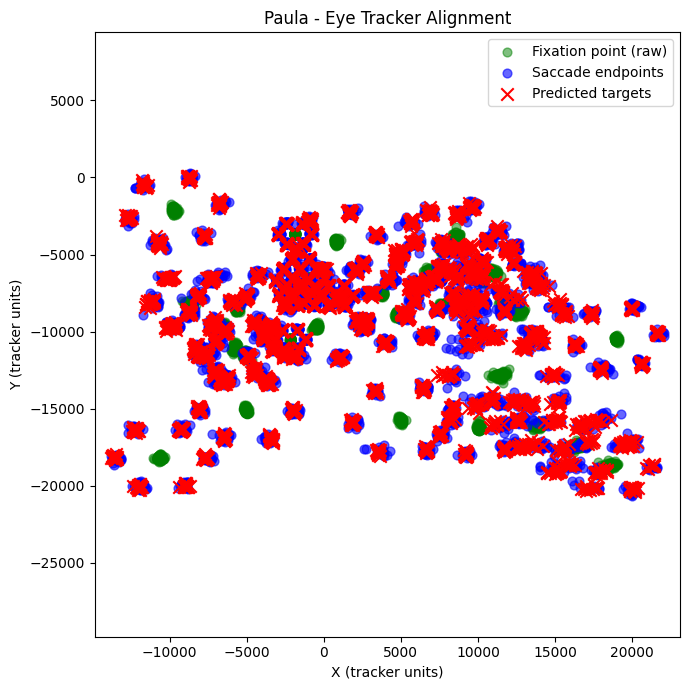

In [14]:
# Paula
plot_eye_endpoints(merged_paula, title="Paula - Eye Tracker Alignment")

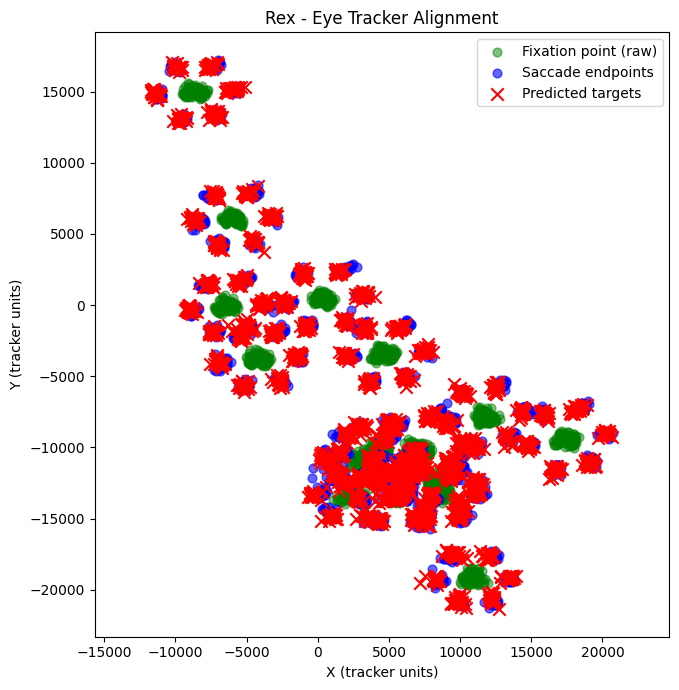

In [15]:
# Rex
plot_eye_endpoints(merged_rex, title="Rex - Eye Tracker Alignment")

In [16]:
merged_paula_with_resp, fit_paula_resp = add_response_metrics(merged_paula)
merged_rex_with_resp,   fit_rex_resp   = add_response_metrics(merged_rex)

# Peek
# for sid, info in list(fit_paula_resp.items())[:3]:
#     print(f"[{sid}] A=\n{info['A']}\nAinv=\n{info['Ainv']}\n")


In [17]:
merged_paula_with_delay = add_memory_delay_features(merged_paula_with_resp)

# Rex
merged_rex_with_delay = add_memory_delay_features(merged_rex_with_resp)

# Quick peek
merged_paula_with_delay[["memoryDelay","curr","prev","diff","err"]]

,memoryDelay,curr,prev,diff,err
0,0.971575,0.0,NaN,NaN,-4.205191
1,0.997950,180.0,0.0,180.0,2.471326
2,1.035975,120.0,180.0,60.0,6.525877
3,1.022100,120.0,120.0,0.0,5.003106
4,1.144175,60.0,120.0,60.0,-15.815104
...,...,...,...,...,...
4347,0.787325,120.0,60.0,60.0,-2.366152
4348,0.849250,0.0,120.0,120.0,-1.479437
4349,0.838250,0.0,0.0,0.0,17.932438
4350,0.864200,-120.0,0.0,120.0,-4.237549


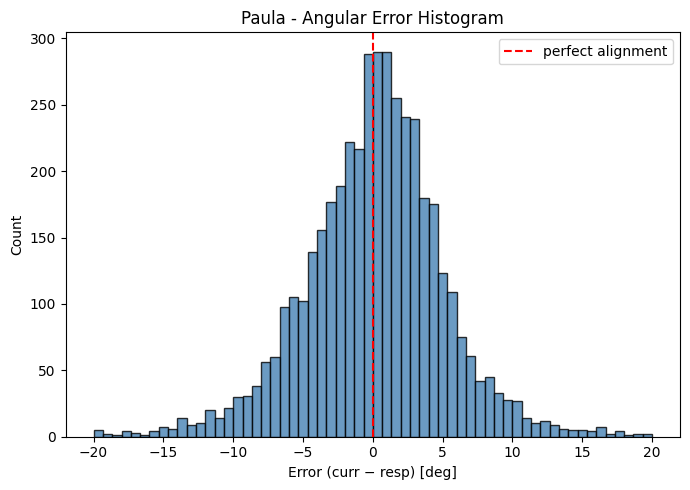

In [18]:
# Paula
plot_error_histogram(merged_paula_with_delay, title="Paula - Angular Error Histogram")

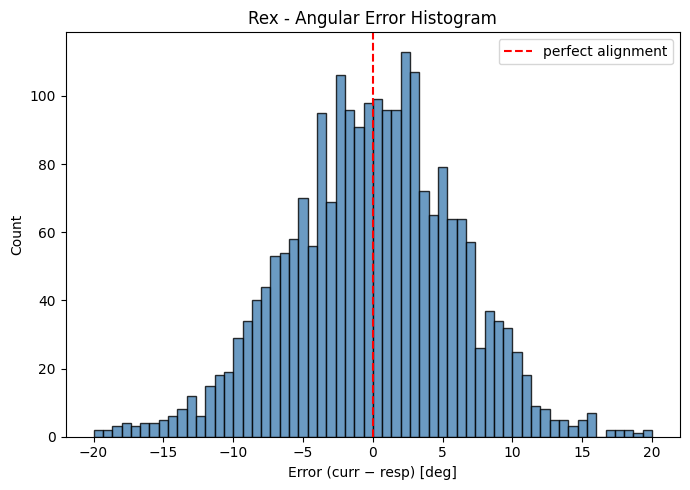

In [19]:
# Rex
plot_error_histogram(merged_rex_with_delay, title="Rex - Angular Error Histogram")

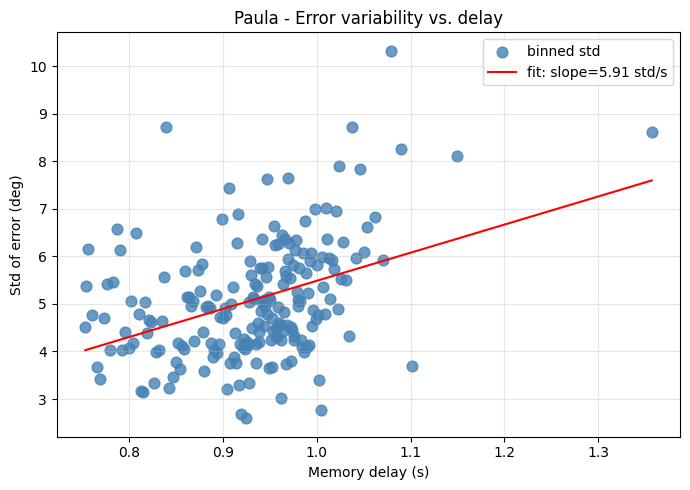

In [20]:
# Paula
plot_error_variability_vs_delay(
    merged_paula_with_delay.rename(columns={"memoryDelay": "delay"}), 
    title="Paula - Error variability vs. delay"
)

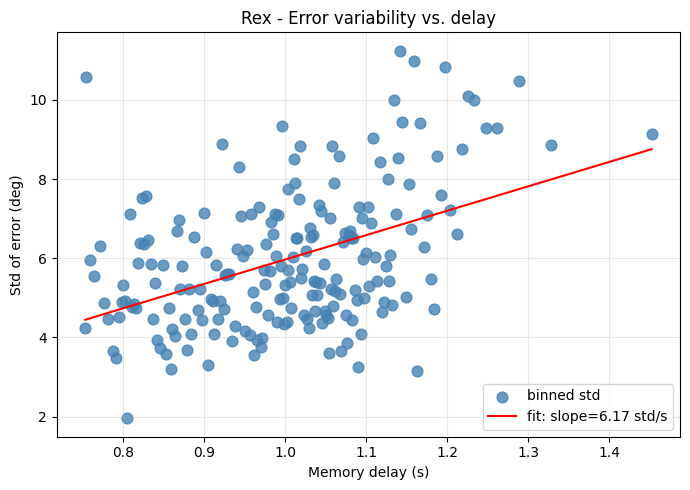

In [21]:
# Rex
plot_error_variability_vs_delay(
    merged_rex_with_delay.rename(columns={"memoryDelay": "delay"}), 
    title="Rex - Error variability vs. delay"
)

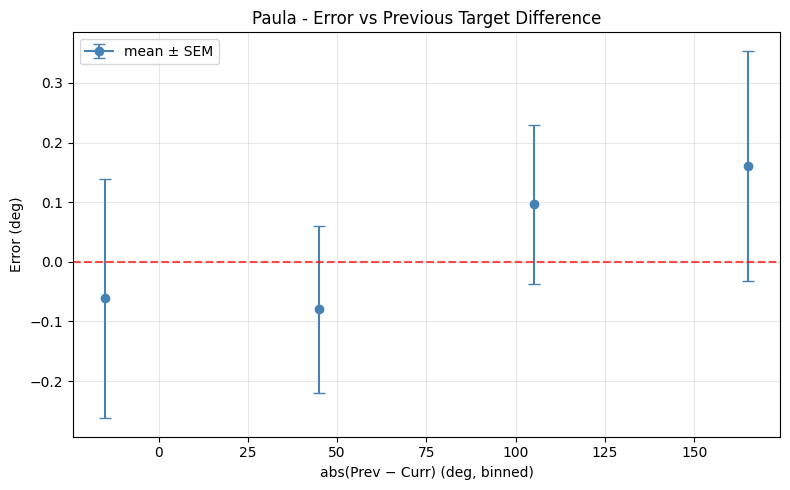

In [22]:
# Paula
plot_error_vs_prev_diff(
    merged_paula_with_delay,
    title="Paula - Error vs Previous Target Difference"
)

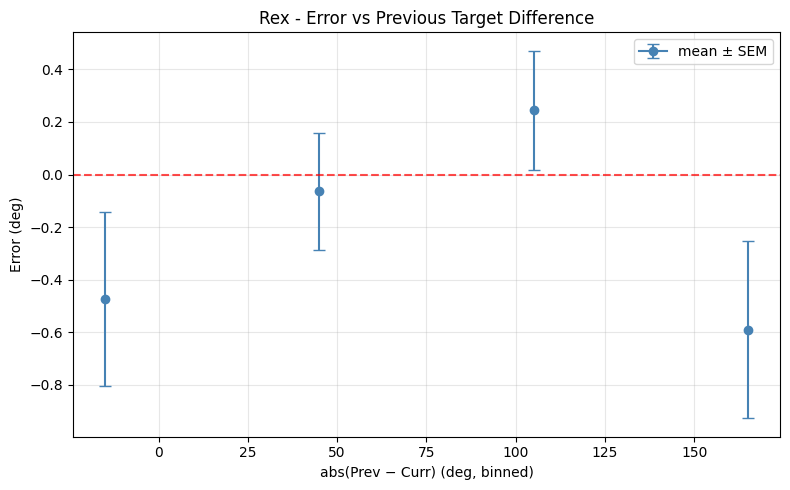

In [23]:
# Rex
plot_error_vs_prev_diff(
    merged_rex_with_delay,
    title="Rex - Error vs Previous Target Difference"
)